In [10]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [11]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [12]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

In [22]:
# integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
values[:, 8] = encoder.fit_transform(values[:, 8])

In [24]:
# ensure all data is float
values = values.astype('float32')

In [25]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [26]:
# specify the number of lag hours
n_hours = 3
n_features = 8

In [27]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(43821, 48)


In [28]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [29]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(8760, 24) 8760 (8760,)


In [30]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 3, 8) (8760,) (35061, 3, 8) (35061,)


In [31]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

c:\Users\pouya\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 2s - 18ms/step - loss: 0.1278 - val_loss: 0.2861
Epoch 2/50
122/122 - 1s - 6ms/step - loss: 0.0911 - val_loss: 0.2888
Epoch 3/50
122/122 - 1s - 6ms/step - loss: 0.0562 - val_loss: 0.2689
Epoch 4/50
122/122 - 1s - 6ms/step - loss: 0.0532 - val_loss: 0.2499
Epoch 5/50
122/122 - 1s - 6ms/step - loss: 0.0528 - val_loss: 0.2151
Epoch 6/50
122/122 - 1s - 6ms/step - loss: 0.0509 - val_loss: 0.1929
Epoch 7/50
122/122 - 1s - 6ms/step - loss: 0.0503 - val_loss: 0.1901
Epoch 8/50
122/122 - 1s - 5ms/step - loss: 0.0501 - val_loss: 0.1716
Epoch 9/50
122/122 - 1s - 6ms/step - loss: 0.0492 - val_loss: 0.1622
Epoch 10/50
122/122 - 1s - 6ms/step - loss: 0.0498 - val_loss: 0.1596
Epoch 11/50
122/122 - 1s - 6ms/step - loss: 0.0492 - val_loss: 0.1432
Epoch 12/50
122/122 - 1s - 6ms/step - loss: 0.0482 - val_loss: 0.1381
Epoch 13/50
122/122 - 1s - 6ms/step - loss: 0.0482 - val_loss: 0.1275
Epoch 14/50
122/122 - 1s - 5ms/step - loss: 0.0476 - val_loss: 0.1138
Epoch 15/50
122/122 - 1s - 6

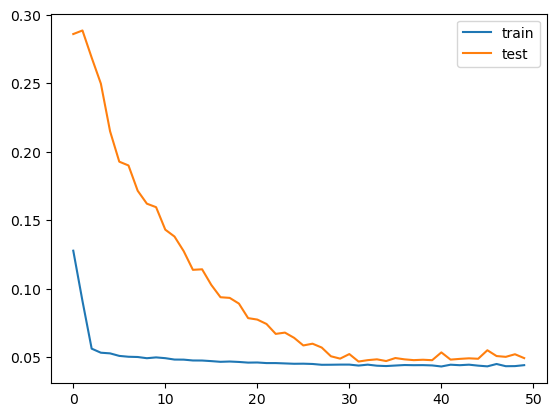

In [33]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [34]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step


In [36]:
print(yhat.shape)
print(test_X[:, -7:].shape)

(35061, 1)
(35061, 7)


In [ ]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = inv_yhat.reshape(-1, scaler.scale_.shape[0])  
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

In [43]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = inv_y.reshape(-1, scaler.scale_.shape[0])  
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [44]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.342
